# GOLEM Fast Spectrometry Analysis

This notebook demonstrates analysis of GOLEM tokamak diagnostic data using the `golem_data_loader` module.

## Features of the data loader:
- **Type-safe**: Full type annotations for better IDE support
- **Robust error handling**: Automatic retries with configurable delays
- **Flexible**: Load all or specific spectroscopy lines
- **Well-documented**: Comprehensive docstrings and examples
- **Easy to use**: Simple API with sensible defaults

In [107]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
from scipy import fft

# Import the GOLEM data loader module
from golem_data_loader import GolemDataLoader, SpectroscopyLine

# Increase global font sizes for readability
plt.rcParams.update(
    {
        "font.size": 12,  # base font size
        "axes.labelsize": 22,  # x/y labels
        "axes.titlesize": 22,  # subplot titles
        "xtick.labelsize": 18,  # x tick labels
        "ytick.labelsize": 18,  # y tick labels
        "legend.fontsize": 18,  # legends
        "figure.titlesize": 20,  # suptitle
    }
)


In [108]:
# Reload golem_data_loader to pick up latest local changes
import importlib
import golem_data_loader
import golem_data_loader.golem_data_loader as _gdl_mod
importlib.reload(_gdl_mod)
from golem_data_loader import GolemDataLoader, SpectroscopyLine

In [109]:
# Inspect loader module path
import golem_data_loader
import golem_data_loader.golem_data_loader as _gdl_mod
print("golem_data_loader file:", golem_data_loader.__file__)
print("golem_data_loader.golem_data_loader file:", _gdl_mod.__file__)
print("GolemDataLoader definition:", _gdl_mod.GolemDataLoader)

golem_data_loader file: c:\GIT\PRPL2025_ZS\golem_data_loader\__init__.py
golem_data_loader.golem_data_loader file: c:\GIT\PRPL2025_ZS\golem_data_loader\golem_data_loader.py
GolemDataLoader definition: <class 'golem_data_loader.golem_data_loader.GolemDataLoader'>


In [110]:
shotno = 50709

## Load Data from GOLEM Web Server

Using the `golem_data_loader` module to fetch diagnostic data with automatic retry logic and error handling.

In [111]:
# Initialize the GOLEM data loader
loader = GolemDataLoader(shotno)

# Load fast spectrometry data
spectrometry_data = loader.load_fast_spectrometry()

# Convert to the original data format for backward compatibility
data = {name: spec_data.raw_dataframe for name, spec_data in spectrometry_data.items()}

# Print loaded data info
for label, spec_data in spectrometry_data.items():
    print(f"{label}: loaded {len(spec_data.time)} rows")

2026-01-21 14:40:24,764 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma start time from http://golem.fjfi.cvut.cz/shots/50709/Diagnostics/PlasmaDetection/Results/t_plasma_start
2026-01-21 14:40:24,831 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma end time from http://golem.fjfi.cvut.cz/shots/50709/Diagnostics/PlasmaDetection/Results/t_plasma_end
2026-01-21 14:40:24,831 - golem_data_loader.golem_data_loader - INFO - Loaded plasma timing: 1.53 - 13.10 ms
2026-01-21 14:40:25,921 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα 656.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50709/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-21 14:40:25,928 - golem_data_loader.golem_data_loader - INFO - Hα 656.5nm: loaded 19999 rows, columns = ['    0', '0.001']
2026-01-21 14:40:26,374 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.

Hα 656.5nm: loaded 19999 rows
Cl II 479.5nm: loaded 19999 rows
He I 588nm: loaded 19999 rows
Whole: loaded 19999 rows
C II 514.5nm: loaded 3999 rows
N II 568.6nm: loaded 3999 rows
O I 777nm: loaded 3999 rows
He I 447.1nm: loaded 3999 rows


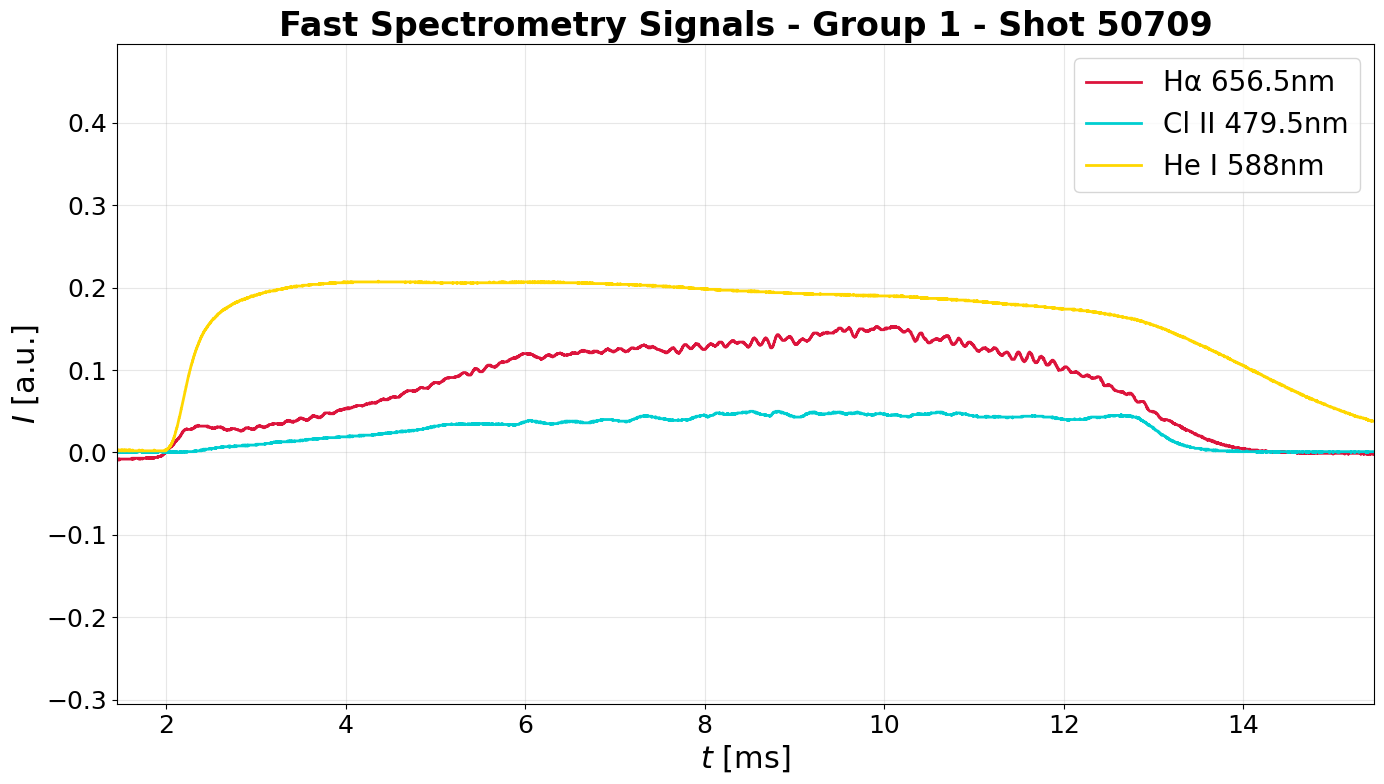

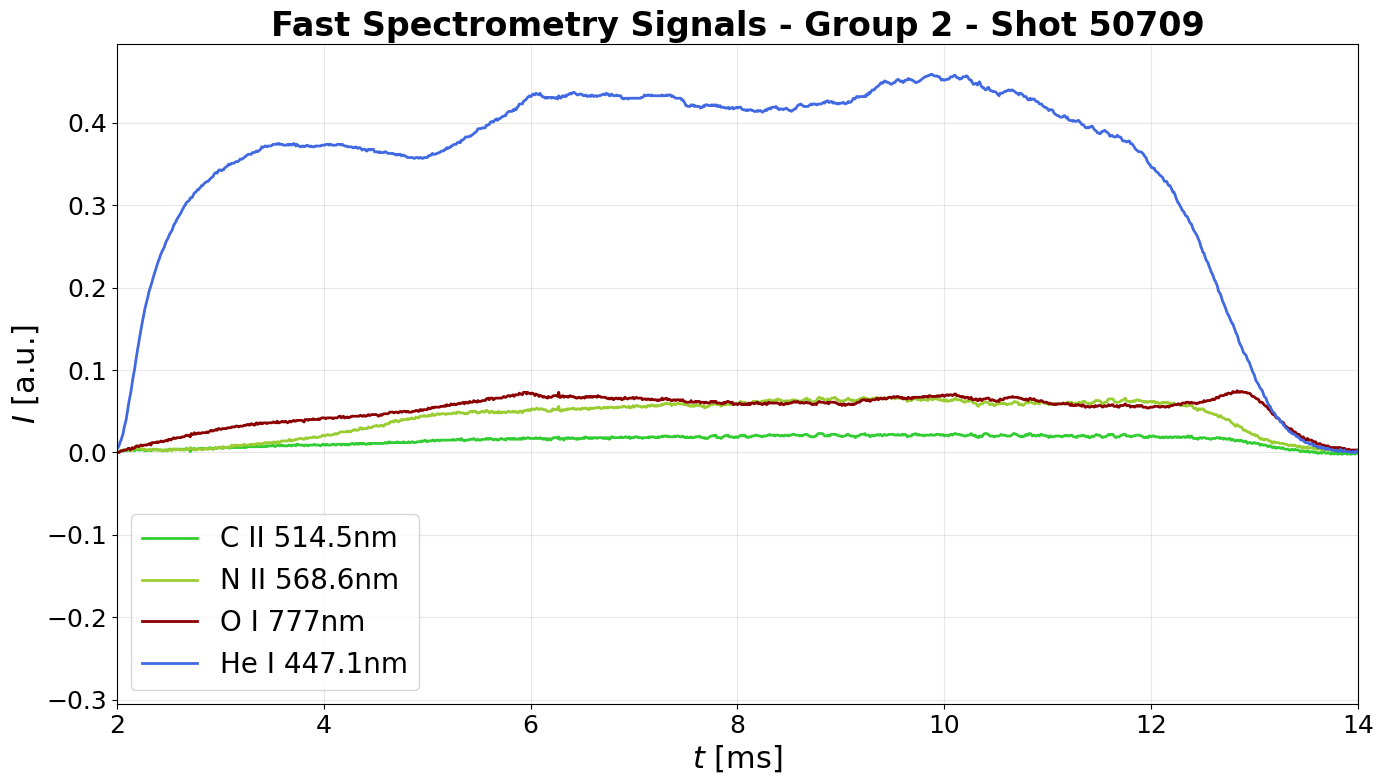

In [122]:
# Define colors for each spectral line based on their wavelengths
line_colors = {
    "Hα 656.5nm": "#DC143C",  # Crimson red (656 nm)
    "Cl II 479.5nm": "#00CED1",  # Dark turquoise (480 nm)
    "He I 588nm": "#FFD700",  # Gold (588 nm)
    "Whole": "#808080",  # Gray (all wavelengths)
    "C II 514.5nm": "#32CD32",  # Lime green (515 nm)
    "N II 568.6nm": "#9ACD32",  # Yellow-green (569 nm)
    "O I 777nm": "#8B0000",  # Dark red (777 nm)
    "He I 447.1nm": "#4169E1",  # Royal blue (447 nm)
}

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

# Collect all data to determine common y-axis limits
all_y_values = []

first_lines = ["Hα 656.5nm", "Cl II 479.5nm", "He I 588nm"]
for label in first_lines:
    if label in data:
        df = data[label]
        u = df.iloc[:, 1]
        all_y_values.extend(u.values)

second_lines = ["C II 514.5nm", "N II 568.6nm", "O I 777nm", "He I 447.1nm"]
for label in second_lines:
    if label in data:
        df = data[label]
        u = df.iloc[:, 1]
        all_y_values.extend(u.values)

# Calculate common y-axis limits with margin
y_min_common = np.min(all_y_values)
y_max_common = np.max(all_y_values)
y_margin = (y_max_common - y_min_common) * 0.05
y_min_common -= y_margin
y_max_common += y_margin

# First figure: 3 lines (Hα, Cl II, He I 588)
fig1, ax1 = plt.subplots(figsize=(14, 8))

for label in first_lines:
    if label in data:
        df = data[label]
        t = df.iloc[:, 0] * 1e3  # convert to ms
        u = df.iloc[:, 1]
        color = line_colors.get(label, "black")
        ax1.plot(t, u, label=label, color=color, linewidth=2)

ax1.set_ylabel(r"$I$ [a.u.]")
ax1.set_xlabel(r"$t$ [ms]")
ax1.grid(True, alpha=0.3)
ax1.set_title(f"Fast Spectrometry Signals - Group 1 - Shot {shotno}", fontweight='bold', fontsize=24)
ax1.legend(loc='best', fontsize=20)

# Set xlim based on plasma timing if available
if loader.plasma_timing:
    ax1.set_xlim(loader.plasma_timing.t_plasma_start_ms, loader.plasma_timing.t_plasma_end_ms + 3)
else:
    ax1.set_xlim(0, 25)

ax1.set_ylim(y_min_common, y_max_common)

fig1.tight_layout()
plt.show()

# Second figure: 4 lines (C II, N II, O I, He I 447)
fig2, ax2 = plt.subplots(figsize=(14, 8))

for label in second_lines:
    if label in data:
        df = data[label]
        t = df.iloc[:, 0] * 1e3  # convert to ms
        u = df.iloc[:, 1]
        color = line_colors.get(label, "black")
        ax2.plot(t, u, label=label, color=color, linewidth=2)

ax2.set_ylabel(r"$I$ [a.u.]")
ax2.set_xlabel(r"$t$ [ms]")
ax2.grid(True, alpha=0.3)
ax2.set_title(f"Fast Spectrometry Signals - Group 2 - Shot {shotno}", fontweight='bold', fontsize=24)
ax2.legend(loc='best', fontsize=20)

# Set xlim from 2 to 14 seconds
ax2.set_xlim(2, 14)

ax2.set_ylim(y_min_common, y_max_common)

fig2.tight_layout()
plt.show()


## He I 447 line for shots 50737-50740

In [113]:
# Load data for shots 50737-50740
shot_numbers = [50737, 50738, 50739, 50740]
he_i_447_data = {}

for shot in shot_numbers:
    print(f"Loading shot {shot}...")
    loader = GolemDataLoader(shot)
    spectrometry_data = loader.load_fast_spectrometry()
    
    # Extract He I 447.1nm data
    if "He I 447.1nm" in spectrometry_data:
        he_i_447_data[shot] = spectrometry_data["He I 447.1nm"]
        print(f"  Loaded {len(he_i_447_data[shot].time)} data points")
    else:
        print(f"  Warning: He I 447.1nm not found for shot {shot}")

print(f"\nSuccessfully loaded data for {len(he_i_447_data)} shots")

2026-01-21 14:40:28,381 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma start time from http://golem.fjfi.cvut.cz/shots/50737/Diagnostics/PlasmaDetection/Results/t_plasma_start
2026-01-21 14:40:28,443 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma end time from http://golem.fjfi.cvut.cz/shots/50737/Diagnostics/PlasmaDetection/Results/t_plasma_end


Loading shot 50737...


2026-01-21 14:40:28,443 - golem_data_loader.golem_data_loader - INFO - Loaded plasma timing: 0.67 - 12.31 ms
2026-01-21 14:40:28,984 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα 656.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50737/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-21 14:40:28,999 - golem_data_loader.golem_data_loader - INFO - Hα 656.5nm: loaded 19999 rows, columns = ['    0', '0.000']
2026-01-21 14:40:29,401 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50737/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch5.csv
2026-01-21 14:40:29,409 - golem_data_loader.golem_data_loader - INFO - Cl II 479.5nm: loaded 19999 rows, columns = ['    0', '0.001']
2026-01-21 14:40:29,827 - golem_data_loader.golem_data_loader - INFO - Successfully loaded He I 588nm spectrometry from http://golem.fjfi.cvut.cz/shots/50737/Diagnostics/FastSpectrometry/DAS_raw_data

  Loaded 3999 data points
Loading shot 50738...


2026-01-21 14:40:31,136 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα 656.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50738/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-21 14:40:31,136 - golem_data_loader.golem_data_loader - INFO - Hα 656.5nm: loaded 19999 rows, columns = ['    0', '0.000']
2026-01-21 14:40:32,070 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50738/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch5.csv
2026-01-21 14:40:32,075 - golem_data_loader.golem_data_loader - INFO - Cl II 479.5nm: loaded 19999 rows, columns = ['    0', '0.000']
2026-01-21 14:40:32,518 - golem_data_loader.golem_data_loader - INFO - Successfully loaded He I 588nm spectrometry from http://golem.fjfi.cvut.cz/shots/50738/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch7.csv
2026-01-21 14:40:32,524 - golem_data_loader.golem_data_loader - INFO - He I 588nm: loaded 19999 

  Loaded 3999 data points
Loading shot 50739...


2026-01-21 14:40:33,681 - golem_data_loader.golem_data_loader - INFO - Loaded plasma timing: 1.47 - 12.55 ms
2026-01-21 14:40:34,102 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα 656.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50739/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-21 14:40:34,105 - golem_data_loader.golem_data_loader - INFO - Hα 656.5nm: loaded 19999 rows, columns = ['    0', '-0.000']
2026-01-21 14:40:34,404 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50739/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch5.csv
2026-01-21 14:40:34,410 - golem_data_loader.golem_data_loader - INFO - Cl II 479.5nm: loaded 19999 rows, columns = ['    0', '0.000']
2026-01-21 14:40:34,758 - golem_data_loader.golem_data_loader - INFO - Successfully loaded He I 588nm spectrometry from http://golem.fjfi.cvut.cz/shots/50739/Diagnostics/FastSpectrometry/DAS_raw_dat

  Loaded 3999 data points
Loading shot 50740...


2026-01-21 14:40:36,416 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα 656.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50740/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-21 14:40:36,423 - golem_data_loader.golem_data_loader - INFO - Hα 656.5nm: loaded 19999 rows, columns = ['    0', '0.000']
2026-01-21 14:40:36,838 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50740/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch5.csv
2026-01-21 14:40:36,843 - golem_data_loader.golem_data_loader - INFO - Cl II 479.5nm: loaded 19999 rows, columns = ['    0', '0.000']
2026-01-21 14:40:37,277 - golem_data_loader.golem_data_loader - INFO - Successfully loaded He I 588nm spectrometry from http://golem.fjfi.cvut.cz/shots/50740/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch7.csv
2026-01-21 14:40:37,281 - golem_data_loader.golem_data_loader - INFO - He I 588nm: loaded 19999 

  Loaded 3999 data points

Successfully loaded data for 4 shots


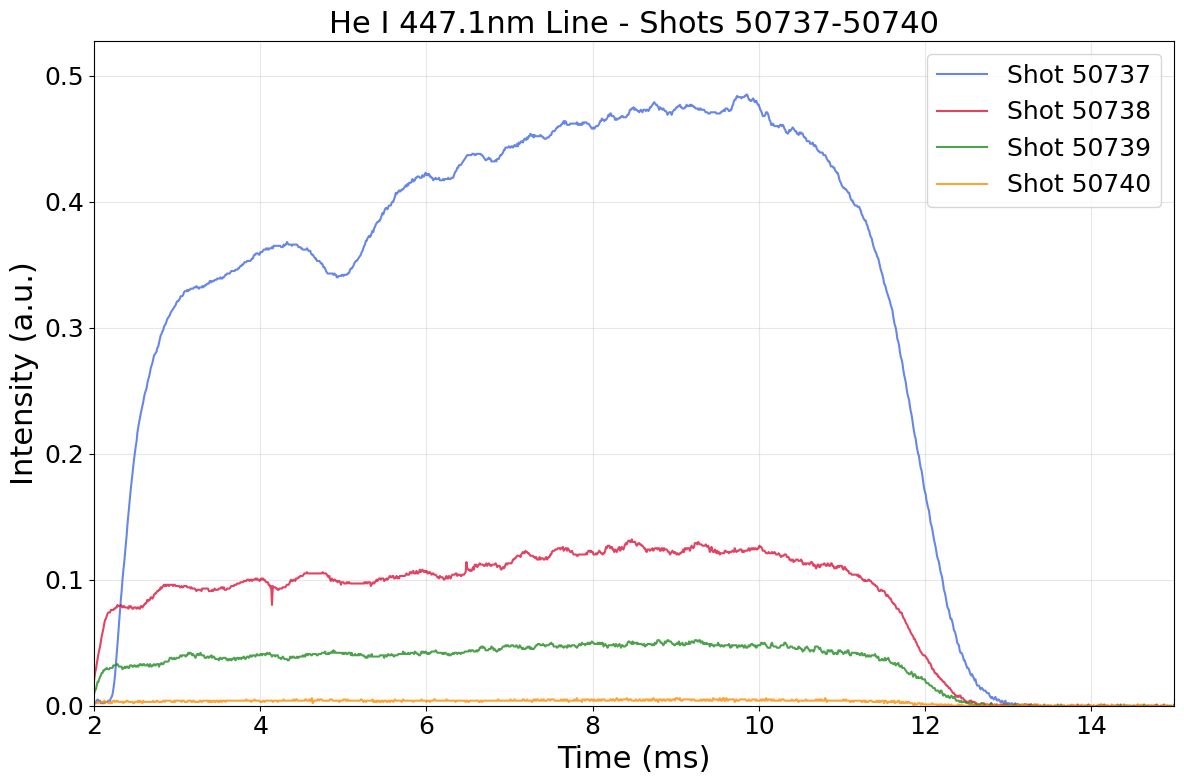

In [114]:
# Plot He I 447.1nm line for all four shots
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00']  # Blue, Crimson, Green, Dark Orange

for i, shot in enumerate(shot_numbers):
    if shot in he_i_447_data:
        spec_data = he_i_447_data[shot]
        ax.plot(spec_data.time * 1000, spec_data.intensity, 
                label=f'Shot {shot}', 
                color=colors[i],
                linewidth=1.5,
                alpha=0.8)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Intensity (a.u.)')
ax.set_title('He I 447.1nm Line - Shots 50737-50740')
ax.set_xlim(2, 15)
ax.set_ylim(0, None)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [115]:
# Load mini-spectrometer H5 data using the loader module
h5_data = loader.load_minispectrometer_h5()

# Extract spectra and wavelengths
Spectra = h5_data.spectra
Wavelengths = h5_data.wavelengths

print(f"Loaded spectra with shape: {Spectra.shape}")
print(f"Wavelength range: {Wavelengths[0]:.2f} - {Wavelengths[-1]:.2f} nm")

2026-01-21 14:40:38,345 - golem_data_loader.golem_data_loader - INFO - Downloading H5 file to C:\Users\pepat\AppData\Local\Temp\tmp15etdr6y.h5
2026-01-21 14:40:38,505 - golem_data_loader.golem_data_loader - INFO - Successfully loaded mini-spectrometer H5 file from http://golem.fjfi.cvut.cz/shots/50740/Diagnostics/MiniSpectrometer/DAS_raw_data_dir/IRVISUV_0.h5
2026-01-21 14:40:38,507 - golem_data_loader.golem_data_loader - INFO - Successfully downloaded H5 file (102864 bytes)
2026-01-21 14:40:38,516 - golem_data_loader.golem_data_loader - INFO - Loaded spectra: shape=(20, 2048), wavelengths: shape=(2047,)
2026-01-21 14:40:38,517 - golem_data_loader.golem_data_loader - WARNING - Mini-spectrometer data has mismatched lengths: spectra=2048, wavelengths=2047; trimming to 2047 columns
2026-01-21 14:40:38,518 - golem_data_loader.golem_data_loader - INFO - Applied ILX511B spectral sensitivity compensation to mini-spectrometer spectra
2026-01-21 14:40:38,518 - golem_data_loader.golem_data_loade

Loaded spectra with shape: (20, 2047)
Wavelength range: 188.11 - 1108.53 nm


In [116]:
# Load quantum efficiency data
qe_data = pd.read_csv('data/quantum_efficiency.csv')
print(f"Loaded quantum efficiency data with shape: {qe_data.shape}")
print(f"Wavelength range: {qe_data['Wavelength (nm)'].min():.2f} - {qe_data['Wavelength (nm)'].max():.2f} nm")
print("\nAvailable channels:")
print([col for col in qe_data.columns if col != 'Wavelength (nm)'])

# Load DET100 silicon photodiode responsivity data
det100_data = pd.read_csv('data/DET100_responsivity.csv')
print(f"\nLoaded DET100 responsivity data with shape: {det100_data.shape}")
print(f"Wavelength range: {det100_data['Wavelength (nm)'].min():.0f} - {det100_data['Wavelength (nm)'].max():.0f} nm")
print(f"Peak responsivity: {det100_data['Responsivity (A/W)'].max():.3f} A/W")

Loaded quantum efficiency data with shape: (10656, 10)
Wavelength range: 200.00 - 2500.00 nm

Available channels:
['O777PP', 'Ha656', 'Hb486', 'Hg434', 'HeI588', 'NII569', 'HeI447', 'ClII479', 'CII515']

Loaded DET100 responsivity data with shape: (44, 2)
Wavelength range: 320 - 1100 nm
Peak responsivity: 0.726 A/W


In [117]:
def compute_mini_spectrometer_intensity(Spectra, Wavelengths, peak_wavelength, fwhm, qe_data=None, qe_channel=None, det100_data=None):
    """
    Compute time-dependent intensity from mini-spectrometer data by integrating over a spectral line.
    
    Parameters:
    -----------
    Spectra : array-like
        2D array of spectra (time x wavelength)
    Wavelengths : array-like
        Wavelength array corresponding to spectral dimension
    peak_wavelength : float
        Central wavelength of the spectral line (nm)
    fwhm : float
        Full width at half maximum for integration window (nm)
    qe_data : DataFrame, optional
        Quantum efficiency data with 'Wavelength (nm)' column
    qe_channel : str, optional
        Column name in qe_data for the specific QE channel to apply
        
    Returns:
    --------
    tuple : (time_array, intensity_array)
        Time array in ms and corresponding integrated intensity values
    """
    # Select wavelengths within +/- (FWHM/2) around the peak wavelength
    wavelength_mask = (Wavelengths >= peak_wavelength - fwhm/2) & (Wavelengths <= peak_wavelength + fwhm/2)
    wavelength_indexes = np.where(wavelength_mask)[0]
    
    # Create time array and integrate intensity for each spectrum
    mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)
    mini_spectrometer_intensity = []
    
    for i in range(len(Spectra)):
        # Extract intensity values at the selected wavelength indexes
        spectrum_slice = Spectra[i][wavelength_indexes]
        
        # Apply DET100 responsivity if available
        if det100_data is not None:
            # Interpolate DET100 responsivity to match the spectrum wavelengths
            det100_resp = np.interp(Wavelengths[wavelength_indexes], 
                                   det100_data['Wavelength (nm)'], 
                                   det100_data['Responsivity (A/W)'],
                                   left=0, right=0)
            # Apply responsivity to the spectrum
            spectrum_slice = spectrum_slice * det100_resp
        
        # Apply quantum efficiency weighting if available
        if qe_channel is not None and qe_data is not None and qe_channel in qe_data.columns:
            # Interpolate QE values to match the spectrum wavelengths
            qe_weights = np.interp(Wavelengths[wavelength_indexes], 
                                  qe_data['Wavelength (nm)'], 
                                  qe_data[qe_channel],
                                  left=0, right=0)  # Use 0 for out-of-range values
            # Apply weights to the spectrum
            spectrum_slice = spectrum_slice * qe_weights
        
        # Integrate using trapezoidal rule
        total_intensity = np.trapezoid(spectrum_slice, Wavelengths[wavelength_indexes])
        mini_spectrometer_intensity.append(total_intensity)
    
    return mini_spectrometer_t, np.array(mini_spectrometer_intensity)

In [118]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def compare_spectrometer(peaks, Wavelengths, Spectra, qe_data, det100_data):
    # First pass: collect all data to find global min/max for normalization
    # Exclude "Whole" from global max calculation
    all_mini_data = []
    all_fast_data = []
    
    for peak in peaks:
        if peak['name'] == "Whole":
            continue  # Skip "Whole" for global max calculation
            
        qe_channel = peak.get("qe_channel", None)
        
        # Collect mini spectrometer data
        _, mini_intensity = compute_mini_spectrometer_intensity(
            Spectra, Wavelengths, peak["wavelength"], peak["fwhm"], qe_data, qe_channel, det100_data
        )
        all_mini_data.extend(mini_intensity)
        
        # Collect fast spectrometer data
        start_index = np.nonzero(peak["fs_data"].iloc[:, 0] > 1e-3)[0][0]
        u_hb = peak["fs_data"].iloc[:, 1][start_index:]
        filtered_hb = butter_lowpass_filter(u_hb, 2000, 100e3)
        all_fast_data.extend(filtered_hb)
    
    # Calculate global min/max for each spectrometer type (excluding "Whole")
    # Assume global min at 0 (physical minimum for intensity data)
    mini_global_max = np.max(all_mini_data)
    fast_global_max = np.max(all_fast_data)
    
    # Second pass: create plots with global normalization
    fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(12, 20))
    axes_flat = axes.flatten()

    for n, peak in enumerate(peaks):
        # Get quantum efficiency weights for this channel
        qe_channel = peak.get("qe_channel", None)
        
        # Compute mini spectrometer intensity using the extracted function
        mini_spectrometer_t, mini_spectrometer_intensity = compute_mini_spectrometer_intensity(
            Spectra, Wavelengths, peak["wavelength"], peak["fwhm"], qe_data, qe_channel, det100_data
        )

        # Plot mini spectrometer integrated intensity over time on the corresponding axis
        ax = axes_flat[n]
        
        # Normalize differently for "Whole" vs other peaks
        if peak['name'] == "Whole":
            # Normalize "Whole" separately using its own max
            mini_normalized = mini_spectrometer_intensity / np.max(mini_spectrometer_intensity)
        else:
            # Use global max for other peaks
            mini_normalized = mini_spectrometer_intensity / mini_global_max
        
        ax.scatter(mini_spectrometer_t, mini_normalized, label='Mini spectrometer')

        # Add gray plot of signal passed through butter_lowpass_filter
        start_index = np.nonzero(peak["fs_data"].iloc[:, 0] > 1e-3)[0][0]
        t_hb = peak["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
        u_hb = peak["fs_data"].iloc[:, 1][start_index:]
        filtered_hb = butter_lowpass_filter(u_hb, 2000, 100e3)
        
        # Normalize differently for "Whole" vs other peaks
        if peak['name'] == "Whole":
            # Normalize "Whole" separately using its own max
            fast_normalized = filtered_hb / np.max(filtered_hb)
        else:
            # Use global max for other peaks
            fast_normalized = filtered_hb / fast_global_max
        
        ax.plot(t_hb, fast_normalized, color='gray', label='Fast spectrometer')

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Integrated Intensity (a.u.)')
        ax.set_title(f"{peak['name']}")
        
        # Set xlim based on plasma timing if available
        if loader.plasma_timing:
            ax.set_xlim(loader.plasma_timing.t_plasma_start_ms - 2, loader.plasma_timing.t_plasma_end_ms + 2)
        
        # Set ylim based on the actual data range in this subplot
        all_values = np.concatenate([mini_normalized, fast_normalized])
        y_min, y_max = all_values.min(), all_values.max()
        y_margin = (y_max - y_min) * 0.1 if y_max > y_min else 0.1
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

        ax.grid(True)
        ax.legend()

    fig.suptitle(f"Mini Spectrometer and Fast Spectrometer Signals - Shot {shotno}", fontsize=16, y=0.995)
    fig.tight_layout()
    plt.show()


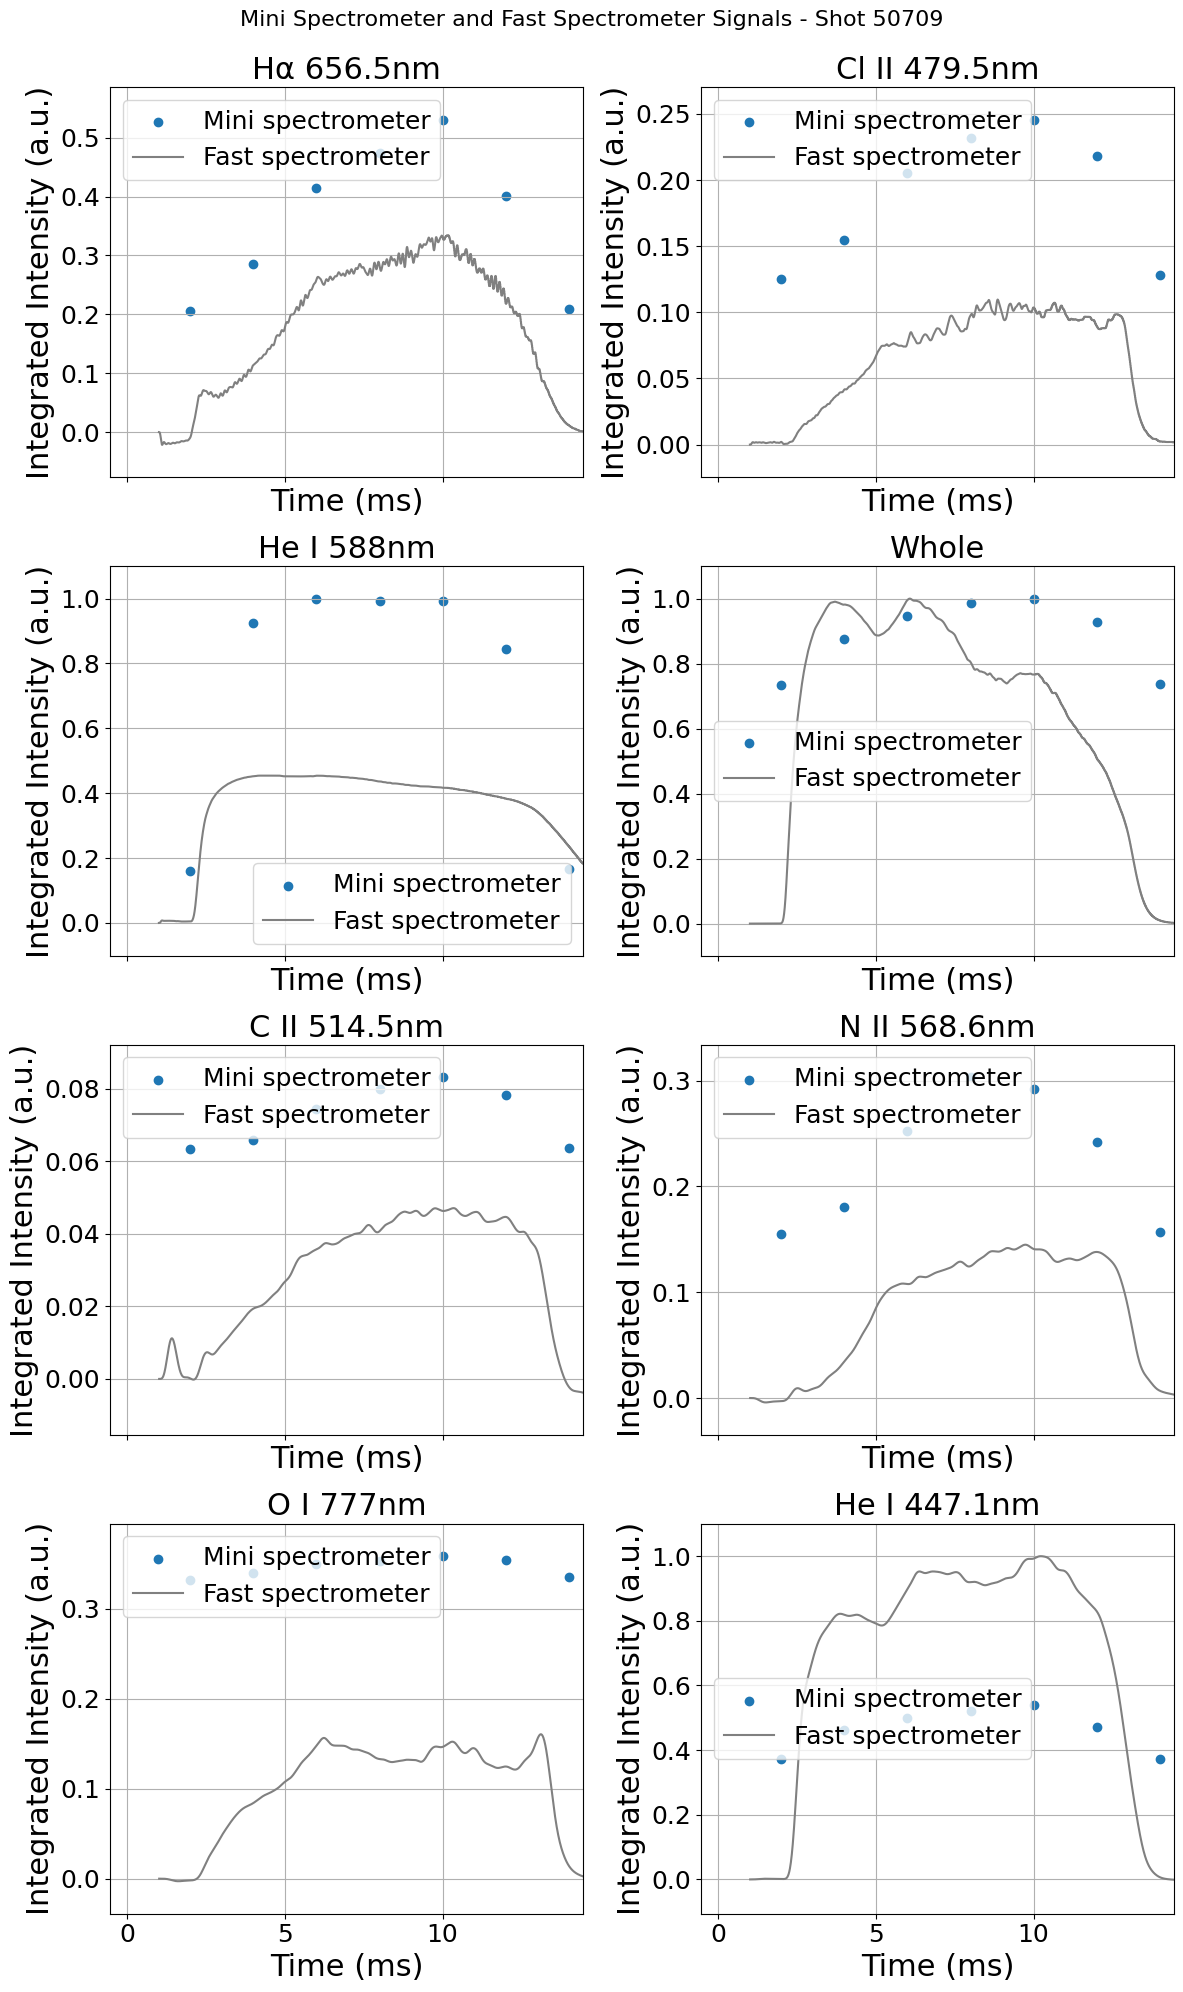

In [119]:
peaks = [
  {
    "name": "Hα 656.5nm",
    "wavelength": 656.0,
    "fwhm": 10,
    "fs_data": data["Hα 656.5nm"],
    "qe_channel": "Ha656"
  },
  {
    "name": "Cl II 479.5nm",
    "wavelength": 480.0,
    "fwhm": 10,
    "fs_data": data["Cl II 479.5nm"],
    "qe_channel": "ClII479"
  },
  {
    "name": "He I 588nm",
    "wavelength": 590.0,
    "fwhm": 10,
    "fs_data": data["He I 588nm"],
    # "fs_data": data["He I 447.1nm"],
    "qe_channel": "HeI588"
  },
  {
    "name": "Whole",
    "wavelength": 500.0,
    "fwhm": 300,
    "fs_data": data["Whole"],
    "qe_channel": None
  },
  {
    "name": "C II 514.5nm",
    "wavelength": 515.0,
    "fwhm": 10,
    "fs_data": data["C II 514.5nm"],
    "qe_channel": "CII515"
  },
  {
    "name": "N II 568.6nm",
    "wavelength": 570.0,
    "fwhm": 10,
    "fs_data": data["N II 568.6nm"],
    "qe_channel": "NII569"
  },
  {
    "name": "O I 777nm",
    "wavelength": 780.0,
    "fwhm": 10,
    "fs_data": data["O I 777nm"],
    "qe_channel": "O777PP"
  },
  {
    "name": "He I 447.1nm",
    "wavelength": 450.0,
    "fwhm": 10,
    "fs_data": data["He I 447.1nm"],
    # "fs_data": data["He I 588nm"],
    "qe_channel": "HeI447"
  }
]

compare_spectrometer(peaks, Wavelengths, Spectra, qe_data, det100_data)

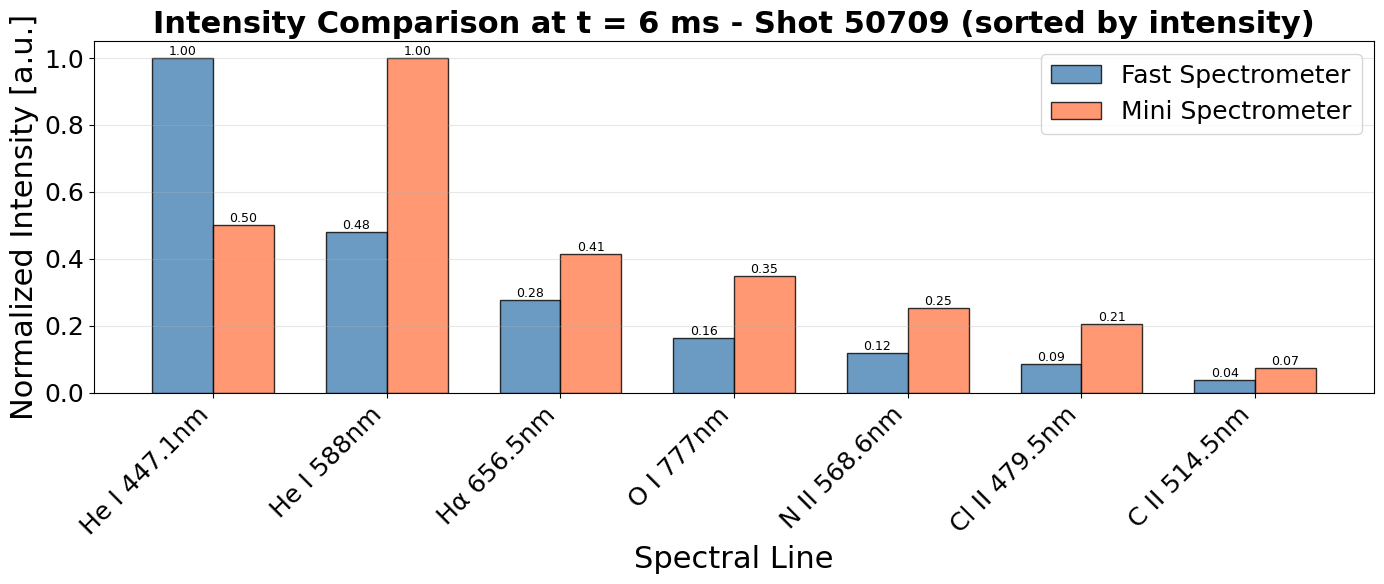


Intensity values at t = 6 ms (sorted by average intensity):
------------------------------------------------------------
He I 447.1nm        : Fast=1.000, Mini=0.501
He I 588nm          : Fast=0.479, Mini=1.000
Hα 656.5nm          : Fast=0.278, Mini=0.415
O I 777nm           : Fast=0.165, Mini=0.350
N II 568.6nm        : Fast=0.118, Mini=0.252
Cl II 479.5nm       : Fast=0.086, Mini=0.205
C II 514.5nm        : Fast=0.039, Mini=0.074


In [120]:
# Time point to compare (in milliseconds)
t = 6  # ms

# Prepare data for histogram
line_names = []
fast_spec_intensities = []
mini_spec_intensities = []

for peak in peaks:
    if peak['name'] == "Whole":
        continue
    
    line_names.append(peak["name"])
    
    # --- Fast Spectrometer intensity at time t ---
    # Get time and intensity data from fast spectrometer
    start_index = np.nonzero(peak["fs_data"].iloc[:, 0] > 1e-3)[0][0]
    t_fs = peak["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
    u_fs = peak["fs_data"].iloc[:, 1][start_index:]
    
    # Interpolate fast spectrometer intensity at time t
    fast_intensity = np.interp(t, t_fs, u_fs)
    fast_spec_intensities.append(fast_intensity)
    
    # --- Mini Spectrometer intensity at time t ---
    # Compute mini spectrometer intensity using the extracted function
    mini_spectrometer_t, mini_spectrometer_intensity = compute_mini_spectrometer_intensity(
        Spectra, Wavelengths, peak["wavelength"], peak["fwhm"], qe_data, peak["qe_channel"], det100_data
    )
    
    # Interpolate mini spectrometer intensity at time t
    mini_intensity = np.interp(t, mini_spectrometer_t, mini_spectrometer_intensity)
    mini_spec_intensities.append(mini_intensity)

# Normalize intensities for comparison (each spectrometer separately)
fast_spec_intensities = np.array(fast_spec_intensities)
mini_spec_intensities = np.array(mini_spec_intensities)

# Normalize to 0-1 range
if fast_spec_intensities.max() > 0:
    fast_spec_normalized = fast_spec_intensities / fast_spec_intensities.max()
else:
    fast_spec_normalized = fast_spec_intensities

if mini_spec_intensities.max() > 0:
    mini_spec_normalized = mini_spec_intensities / mini_spec_intensities.max()
else:
    mini_spec_normalized = mini_spec_intensities

# Sort by average intensity (descending order)
avg_intensity = (fast_spec_normalized + mini_spec_normalized) / 2
sort_indices = np.argsort(avg_intensity)[::-1]  # descending order

line_names_sorted = [line_names[i] for i in sort_indices]
fast_spec_sorted = fast_spec_normalized[sort_indices]
mini_spec_sorted = mini_spec_normalized[sort_indices]

# Create the bar chart
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(line_names_sorted))
width = 0.35

bars1 = ax.bar(x - width/2, fast_spec_sorted, width, label='Fast Spectrometer', 
               color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, mini_spec_sorted, width, label='Mini Spectrometer', 
               color='coral', alpha=0.8, edgecolor='black')

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Spectral Line')
ax.set_ylabel('Normalized Intensity [a.u.]')
ax.set_title(f'Intensity Comparison at t = {t} ms - Shot {shotno} (sorted by intensity)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(line_names_sorted, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nIntensity values at t = {t} ms (sorted by average intensity):")
print("-" * 60)
for i, name in enumerate(line_names_sorted):
    print(f"{name:20s}: Fast={fast_spec_sorted[i]:.3f}, Mini={mini_spec_sorted[i]:.3f}")


Fast spectrometer data shape: (8, 20)
Mini spectrometer data shape: (8, 20)
Applied per-timestep normalization across all spectral lines


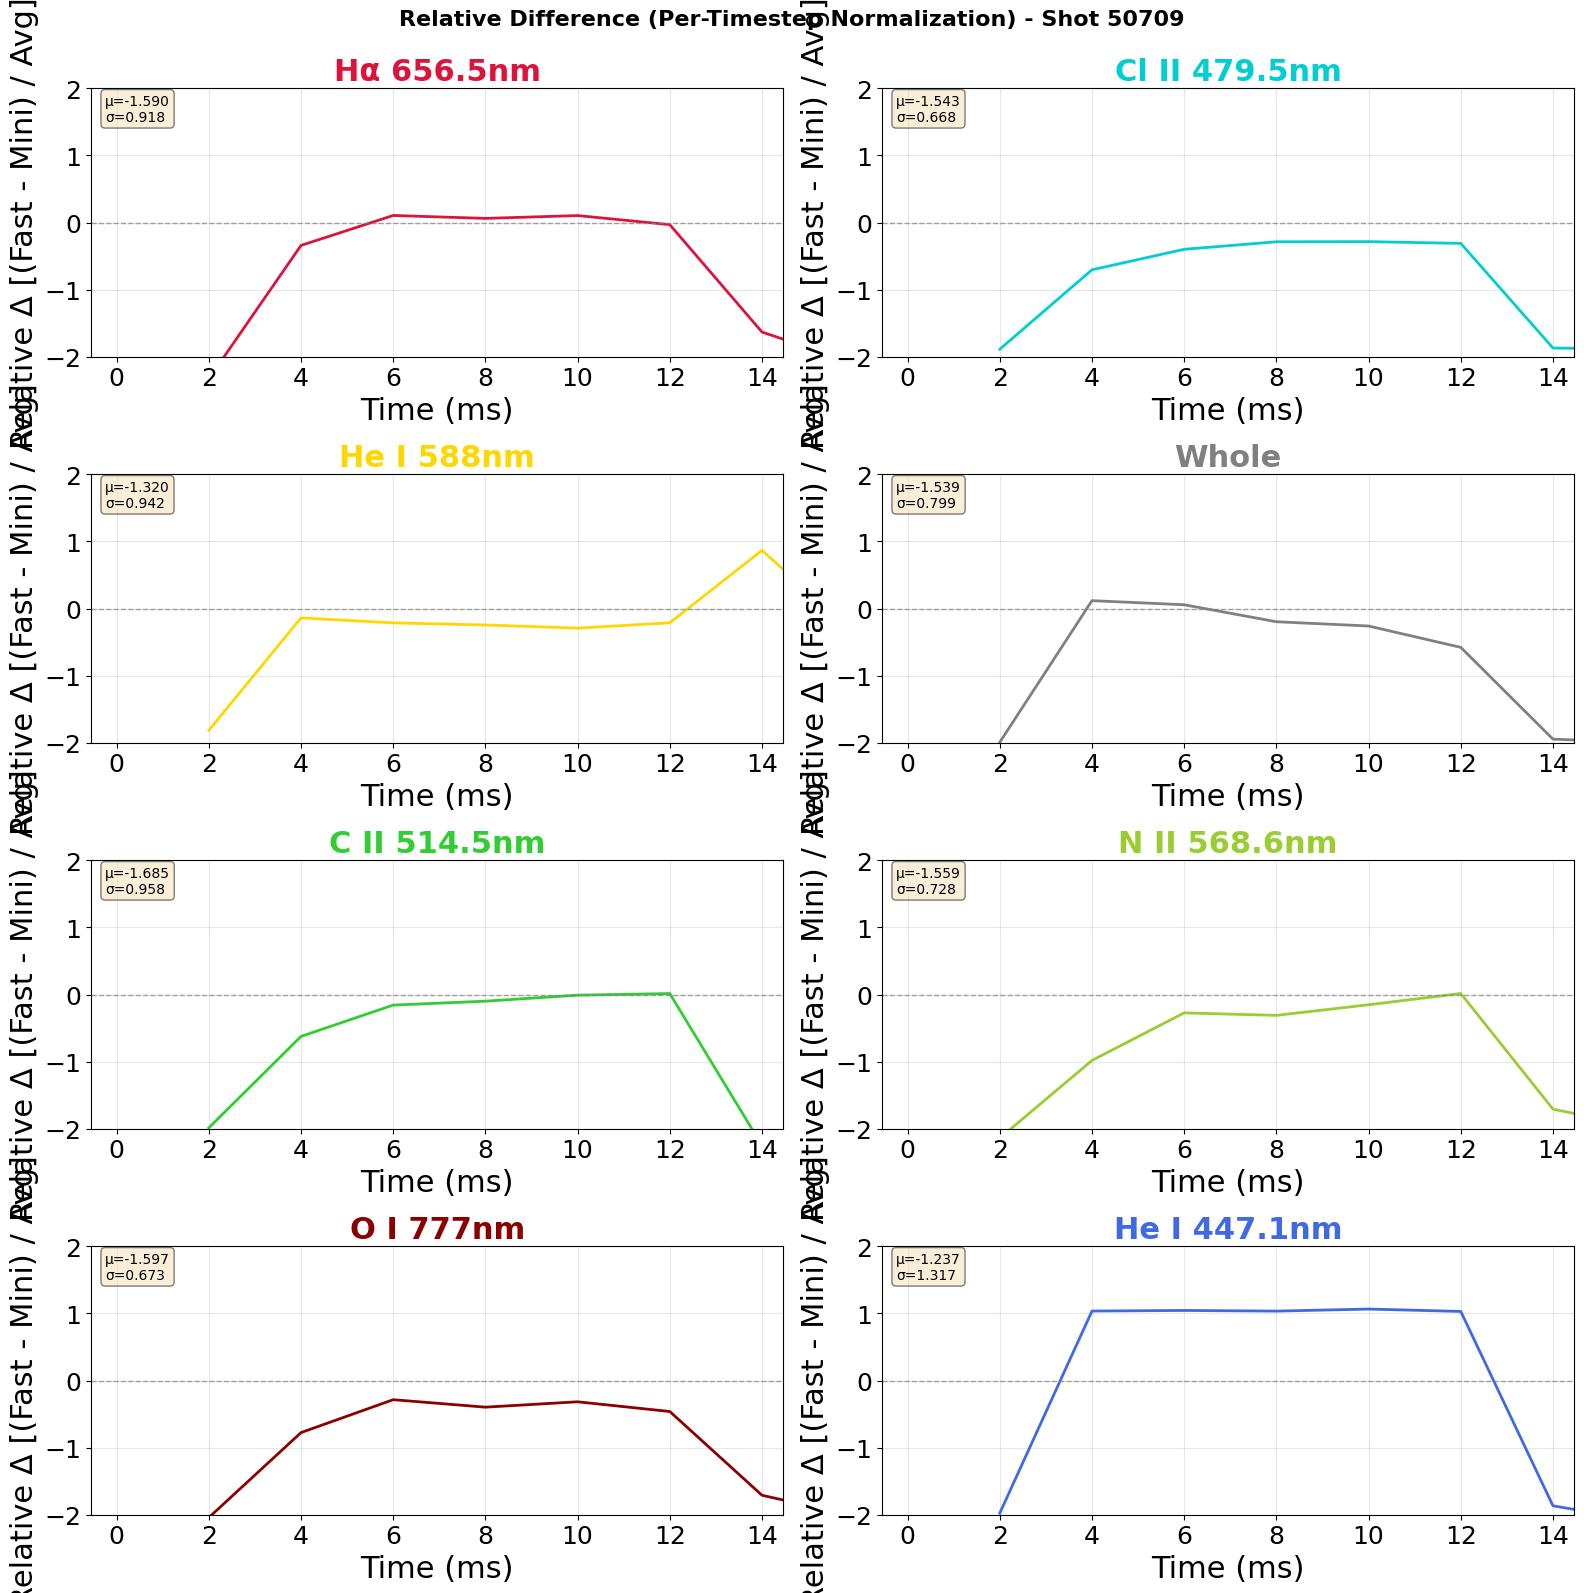

In [121]:
# Plot the difference between normalized fast and mini spectrometer signals
# Apply normalization at each time step separately across all spectral lines

# First pass: collect all data and interpolate to common time base
all_fast_data = []
all_mini_data = []

# Get mini spectrometer time array (common for all lines)
mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)

for peak in peaks:
    # if peak['name'] == "Whole":
    #     continue
    # --- Fast Spectrometer signal ---
    start_index = np.nonzero(peak["fs_data"].iloc[:, 0] > 1e-3)[0][0]
    t_fs = peak["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
    u_fs = peak["fs_data"].iloc[:, 1][start_index:]
    filtered_fs = butter_lowpass_filter(u_fs, 2000, 100e3)
    
    # Interpolate fast spectrometer to mini spectrometer time base
    fast_interpolated = np.interp(mini_spectrometer_t, t_fs, filtered_fs)
    all_fast_data.append(fast_interpolated)
    
    # --- Mini Spectrometer signal ---
    _, mini_spectrometer_intensity = compute_mini_spectrometer_intensity(
        Spectra, Wavelengths, peak["wavelength"], peak["fwhm"], qe_data, peak["qe_channel"], det100_data
    )
    all_mini_data.append(mini_spectrometer_intensity)

# Convert to numpy arrays for easier manipulation (shape: [n_lines, n_timepoints])
all_fast_data = np.array(all_fast_data)
all_mini_data = np.array(all_mini_data)

print(f"Fast spectrometer data shape: {all_fast_data.shape}")
print(f"Mini spectrometer data shape: {all_mini_data.shape}")

fast_max_global = np.max(all_fast_data[1:-1,:])
mini_max_global = np.max(all_mini_data)

# Normalize at each time step across all spectral lines
# For each time point, normalize all 8 spectral line values together
normalized_fast = np.zeros_like(all_fast_data)
normalized_mini = np.zeros_like(all_mini_data)

for t_idx in range(all_fast_data.shape[1]):
    # Get all spectral line values at this time point
    fast_at_t = all_fast_data[:, t_idx]
    mini_at_t = all_mini_data[:, t_idx]
    
    # Normalize across spectral lines at this time point
    fast_min, fast_max = fast_at_t.min(), fast_at_t.max()
    mini_min, mini_max = mini_at_t.min(), mini_at_t.max()
    
    normalized_fast[:, t_idx] =  fast_at_t /fast_max_global

    normalized_mini[:, t_idx] = mini_at_t / mini_max_global

print("Applied per-timestep normalization across all spectral lines")

# Second pass: plot with per-timestep normalization
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
axes_flat = axes.flatten()

for n, peak in enumerate(peaks):
    # Get the normalized data for this spectral line
    normalized_fs = normalized_fast[n, :]
    normalized_mini_line = normalized_mini[n, :]
    
    # Calculate relative difference: (fast - mini) / average
    average = (normalized_fs + normalized_mini_line) / 2
    epsilon = 1e-10
    relative_difference = (normalized_fs - normalized_mini_line) / (average + epsilon)
    
    # Plot on the corresponding axis
    ax = axes_flat[n]
    ax.plot(mini_spectrometer_t, relative_difference, linewidth=2, 
            color=line_colors.get(peak['name'], 'black'))
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Relative Δ [(Fast - Mini) / Avg]')
    ax.set_title(f"{peak['name']}", 
                 color=line_colors.get(peak['name'], 'black'), 
                 fontweight='bold')
    
    # Set xlim based on plasma timing if available
    if loader.plasma_timing:
        ax.set_xlim(loader.plasma_timing.t_plasma_start_ms - 2, 
                    loader.plasma_timing.t_plasma_end_ms + 2)
    
    # Set consistent y-axis limits across all subplots
    ax.set_ylim(-2, 2)
    
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    mean_diff = np.mean(relative_difference)
    std_diff = np.std(relative_difference)
    ax.text(0.02, 0.98, f'μ={mean_diff:.3f}\nσ={std_diff:.3f}',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle(f'Relative Difference (Per-Timestep Normalization) - Shot {shotno}', 
             fontsize=16, y=0.995, fontweight='bold')
fig.tight_layout()
plt.show()
